# A. Import Dependencies

In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import time
import datetime as dt
import requests
from operator import add
import matplotlib.pyplot as plt
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay
from polygon import RESTClient

# B. Obtain Data

## I. Check the Close/Open Price Data Format

In [3]:
key = ''#insert API Key Here
client = RESTClient(key)
resp = client.stocks_equities_daily_open_close("SKYY", "2020-03-12")
resp.__dict__

{'status': 'OK',
 'from_': '2020-03-12',
 'symbol': 'SKYY',
 'open': 48.84,
 'high': 51.08,
 'low': 47.81,
 'close': 48.01,
 'volume': 1392154,
 'after_hours': 51.66,
 'preMarket': 49.04}

## II. Set End Date and Number of Days Back to Obtain Data

In [4]:
security = 'QQQ'#ticker
end_date = dt.date(2020, 6, 18)
num_days_back = 7300#should be atleast 101 days (to have atleast 100 samples of a 2-day holding period),
#if you want to look at 3-day holding periods, you will need atleast 102 days, etc.

## III. Create a DF of Days to Check Close Prices

In [5]:
start_date = end_date-dt.timedelta(days=num_days_back)
trading_years = np.linspace(start_date.year, end_date.year, end_date.year-start_date.year + 1).astype(int)
datelist = pd.bdate_range(end=end_date, periods=num_days_back)
df = pd.DataFrame(index=datelist)
df.head()

""
1992-06-26
1992-06-29
1992-06-30
1992-07-01
1992-07-02


## IV. Class/Function to create DF w Indices of Trading Holidays for removal From Main DF
### (So we don't make calls to the API for data from these days since it would raise an error)

In [6]:
class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)
    ]

def get_trading_close_holidays(year):
    inst = USTradingCalendar()
    return inst.holidays(dt.datetime(year-1, 12, 31), dt.datetime(year, 12, 31))

## V. Remove the Trading Holidays From the Main DF We'll Use to Make Calls to the API

In [7]:
for year in trading_years:
    holidays = get_trading_close_holidays(year)
    df.drop(holidays, errors='ignore', inplace=True)
df.head()

""
1992-06-26
1992-06-29
1992-06-30
1992-07-01
1992-07-02


## VI. Make Calls to the API to Get Close Prices on These Days

In [8]:
close_price_list = []
no_data_days = []
for day in df.index:
    try:
        close_price_list.append(client.stocks_equities_daily_open_close(security, day.date().isoformat()).close)
    except requests.HTTPError as exception:
        print(exception)
        no_data_days.append(day)
    finally:
        continue
df.drop(no_data_days, inplace=True)
df['Close Price'] = close_price_list

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-06-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-06-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-06-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-07-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-07-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-07-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-07-06?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-09-22?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1992-12-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-02-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-02-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-02-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-02-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-02-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-03-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-03-02?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-05-19?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-07-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-07-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-07-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-08-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-08-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-08-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-08-05?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1993-10-27?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-01-14?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-03-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-03-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-03-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-03-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-04-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-04-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-04-05?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-06-27?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-09-15?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-11-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-11-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-11-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-11-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-12-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-12-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1994-12-05?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-02-22?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-05-11?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-07-28?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-10-17?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-12-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-12-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-12-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1995-12-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-01-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-01-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-01-03?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-03-25?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-06-13?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-08-30?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1996-11-18?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-01-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-01-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-02-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-02-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-02-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-02-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-02-07?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-04-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-04-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-04-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-04-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-04-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-05-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-05-02?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-07-23?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-10-09?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1997-12-26?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-03-18?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-06-09?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-08-31?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1998-11-17?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-01-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-01-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-01-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-02-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-02-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-02-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-02-04?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-04-27?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-07-19?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-09-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-10-08?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/1999-12-27?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-03-20?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-06-09?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-08-31?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2000-11-24?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-02-20?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-05-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-07-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-08-01?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2001-10-23?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-01-16?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-04-12?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-06-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-06-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-07-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-07-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-07-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-07-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-07-08?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-09-25?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2002-12-16?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-02-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-03-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-05-29?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-08-20?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-10-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2003-11-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2004-12-29?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-03-23?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-06-14?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-08-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-08-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-08-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-08-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-08-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-09-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-09-02?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2005-11-25?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-02-21?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-05-15?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-07-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-07-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-08-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-08-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-08-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-08-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-08-07?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2006-10-27?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-01-23?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-12?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-04-13?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-06-25?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-06-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-06-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-06-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-06-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-07-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-07-03?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-09-21?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2007-12-12?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-02-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-03-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-05-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-05-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-05-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-05-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-05-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-06-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-06-03?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-13?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-08-21?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-10-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2008-11-10?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-01-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-01-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-01-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-01-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-02-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-02-03?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-02-04?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-04-30?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-20?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-07-22?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-05?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-06?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-10-09?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-21?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-24?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-28?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-29?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2009-12-30?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-23?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-03-24?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-04?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-06-14?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-08-26?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-08-27?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-08-30?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-08-31?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-09-01?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-09-02?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-09-03?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-15?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-16?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-17?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-18?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-19?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-22?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2010-11-23?apiKey=vetnjcAE_Q

500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-07?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-08?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-09?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-10?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-11?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-14?apiKey=vetnjcAE_Ql7R_OBo1a529HpeAGQkdsynV6u_d
500 Server Error: Internal Server Error for url: https://api.polygon.io/v1/open-close/QQQ/2011-02-15?apiKey=vetnjcAE_Q

In [9]:
df.head()

,Close Price
2004-01-02,36.360
2004-01-05,37.090
2004-01-06,37.340
2004-01-07,37.680
2004-01-08,37.979


In [10]:
df.tail()

,Close Price
2020-06-12,235.88
2020-06-15,238.75
2020-06-16,242.85
2020-06-17,243.62
2020-06-18,244.28


# C. Analysis

## I. Plot Data

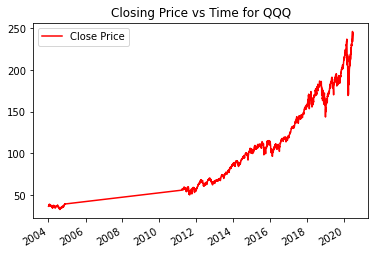

In [11]:
df.plot(kind='line',color='red')
plt.title('Closing Price vs Time for ' + str(security))
plt.show()

## II. Set Minimum Sample Size for all Holding Periods

In [12]:
total_days = df.size
min_sample_size = 100 #minimum number of holding periods to look at each iteration
max_num_days_in_curr_holding_period = total_days-min_sample_size+1
num_days_in_curr_holding_period = 2

In [13]:
#days_offset = total_days%num_days_in_curr_holding_period#calculate number of days by which to offset the first holding period from the start of the data
#indices = list(map(add, first_indices_to_get, len(indices_to_get) * [holding_period * num_days_in_curr_holding_period]))

## III. Obtain Price Data, Compute Returns, Expected Return, Standard Deviation of Returns for all Holding Periods

### (Use unsorted dictionaries for faster computation)

In [14]:
returns_dic = {}
standard_deviations_dic = {}
return_expectations_dic = {}
while num_days_in_curr_holding_period <= max_num_days_in_curr_holding_period:
    num_holding_periods = total_days-num_days_in_curr_holding_period + 1#number of holding periods of n days in data set
    indices = list(range(num_days_in_curr_holding_period))#initialize indices to first n days
    returns = []
    for holding_period in range(num_holding_periods):
        close_price_data = df.iloc[indices]
        returns.append((close_price_data.iloc[close_price_data.size-1].at['Close Price']/close_price_data.iloc[0].at['Close Price']) - 1)
        indices = list(map(add, indices, len(indices) * [1]))#add one to each index (list version of index+=1)
    returns_dic[num_days_in_curr_holding_period] = returns
    return_expectations_dic[num_days_in_curr_holding_period] = np.mean(returns)
    standard_deviations_dic[num_days_in_curr_holding_period] = np.std(returns, ddof=1)#sample standard deviation
    num_days_in_curr_holding_period += 1

## IV. Sort Unsorted Dictionaries with Data for Plotting

In [15]:
returns_sorted = sorted(returns_dic.items()) # sorted by key, return a list of tuples
num_days_held, returns = zip(*returns_sorted) # unpack a list of pairs into two tuples

return_expectations = sorted(return_expectations_dic.items()) # sorted by key, return a list of tuples
num_days_held, return_expectations = zip(*return_expectations) # unpack a list of pairs into two tuples

standard_deviations = sorted(standard_deviations_dic.items()) # sorted by key, return a list of tuples
num_days_held, standard_deviations = zip(*standard_deviations) # unpack a list of pairs into two tuples

## V. Plot Data

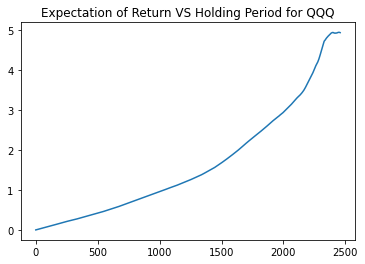

In [16]:
plt.plot(num_days_held, return_expectations)
plt.title('Expectation of Return VS Holding Period for ' + str(security))
plt.show()

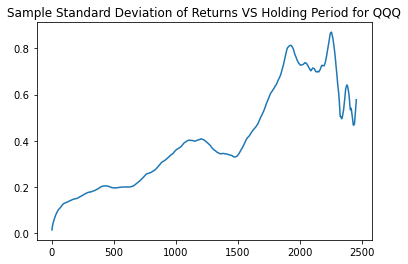

In [17]:
plt.plot(num_days_held, standard_deviations)
plt.title('Sample Standard Deviation of Returns VS Holding Period for ' + str(security))
plt.show()

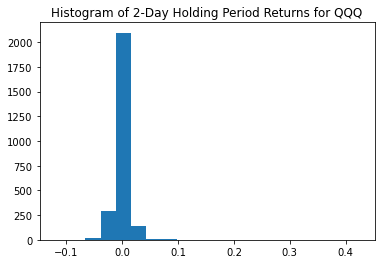

In [18]:
plt.hist(returns_dic[2], bins = 20)
plt.title ('Histogram of 2-Day Holding Period Returns for ' + str(security))
plt.show()

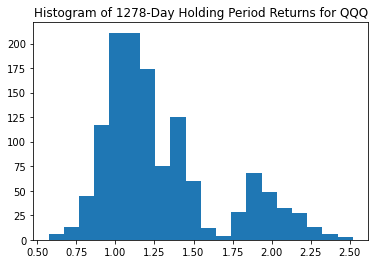

In [19]:
plt.hist(returns_dic[total_days//2], bins = 20)
plt.title('Histogram of ' + str(total_days//2) +\
         '-Day Holding Period Returns for ' + str(security))
plt.show()

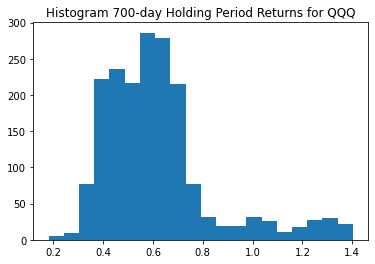

In [20]:
plt.hist(returns_dic[700], bins = 20)
plt.title('Histogram 700-day Holding Period Returns for ' + str(security))
plt.show()

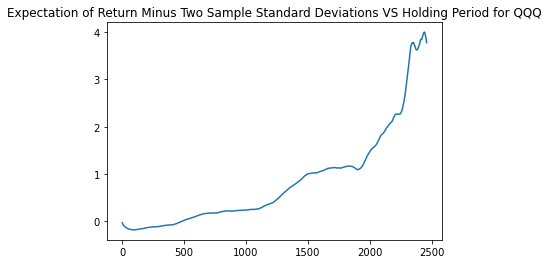

In [21]:
lower_estimate = [a - 2*b for a, b in zip(return_expectations, standard_deviations)]
plt.plot(num_days_held, lower_estimate)
plt.title('Expectation of Return Minus Two Sample Standard Deviations VS Holding Period for ' + str(security))
plt.show()